In [4]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import _pickle as pickle
import gym
import time
import matplotlib.pyplot as plt

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 100
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = True

In [2]:
!python -m atari_py.import_roms .

copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Je

copying mr_do.bin from ROMS/Mr. Do! (1983) (CBS Electronics, Ed English) (4L4478) (PAL).bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/mr_do.bin
copying ms_pacman.bin from ROMS/Ms. Pac-Man (1983) (Atari - GCC, Mark Ackerman, Glenn Parker) (CX2675) ~.bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/ms_pacman.bin
copying name_this_game.bin from ROMS/Name This Game (Guardians of Treasure) (1983) (U.S. Games Corporation - JWDA, Roger Booth, Sylvia Day, Ron Dubren, Todd Marshall, Robin McDaniel, Wes Trager, Henry Will IV) (VC1007) ~.bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/name_this_game.bin
copying pacman.bin from ROMS/Pac-Man (1982) (Atari, Tod Frye) (CX2646) (PAL).bin to /Users/roryliao/opt/anaconda3/lib/python3.8/site-packages/atari_py/atari_roms/pacman.bin
copying phoenix.bin from ROMS/Phoenix (1983) (Atari - GCC, Mike Feinstein, John Mracek) (CX2673) ~.bin to /Users/ro

In [19]:
# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb')) #This allows you to resume training
else:
    model = {} 
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def relu(x):
    if x < 0:
        return 0
    return x

def tanh(x):
    return np.tanh(x)

def softmax(x): 
    pass

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)): #Reward 0 either means every frame that it doesn't score or get scored on
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render: 
        env.render()
        #time.sleep(0.1) Slows down the code if you ever need it

    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None

    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print ('ep %d: game finished, reward: %f' % (episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))

ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000


KeyboardInterrupt: 

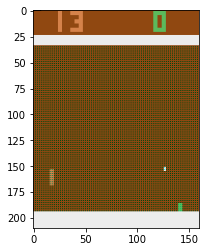

In [21]:
fig = plt.figure()
plt.imshow(observation)
plt.savefig("OriginalImage.png")

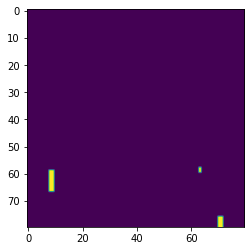

In [22]:
fig1 = plt.figure()
observation = observation[35:195]
observation = observation[::2,::2,0] 
observation[observation == 144] = 0 
observation[observation == 109] = 0 
observation[observation != 0] = 1
plt.imshow(observation)
plt.savefig("NewImage.png")